# Big Mart sales forecast
This notebook presents an analysis of the 2013 sales of Big Mart. The data set contains the sales in 2013 for 1559 different items across 10 stores. Note that not all items are sold in each store. In total, there are 8522 instances in the data set. The data set provides information on both, the individual items (such as the maximum retail price or the weight of the item) and on the different stores (such as the type of store and its size and location).

In the following, I will use this data set to predict the sales for each item in the individual stores. Hence, this is a regression problem. I will use Python, particularly the scikit-learn module. Such a model could predict the sales of new products in the different outlets. Alternatively, the resulting model can be used to predict the sales of the individual items in a new outlet. As explained in the README, such a prediction can also be made based on the sales in the existing stores (see predict_single_store.ipynb for such a model).

More information about the data set are available [here](https://www.kaggle.com/arashnic/big-mart-sale-forecast).

In [1]:
# Import the relevant modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_error

## Auxiliary functions
Below are some functions that are used later in the notebook.

In [2]:
def load_data(filename):
    '''Reads the data, divides into features and labels.
    Takes the square root of the labels because they exhibit a strongly right skewed distribution.
    Returns the features and the label.'''
    
    data = pd.read_csv('train.csv')
    
    X = data.drop('Item_Outlet_Sales',axis=1)
    y = data['Item_Outlet_Sales']
    y = np.sqrt(y)
    
    return X,y



def add_item_num(data):
    '''Reads the train or the test data, adds a feature that contains the number of items (Item_Num) that are avaliable in a given store.
    Returns the dataframe with the column "Item_Num" added.'''
    
    Item_Num = data['Outlet_Identifier'].value_counts().reset_index()
    Item_Num.rename(columns={'index':'Outlet_Identifier','Outlet_Identifier':'Item_Num'},inplace=True)
    data_item = data.merge(Item_Num,on='Outlet_Identifier',how='left')
    data_item.set_index(data.index,inplace=True)
    
    return data_item



def feature_engineering_num(X_train,X_test):
    '''Takes the train and the test data, performs preprocessing and feature engineering for the numerical features.'''
    
    # The relevant numerical features are "Item_MRP" (the maximum retail price or list price of a given product)
    # and "Item_Num" (the number of items for sale in a store). These two features do not exhibit any missing data.
    # Including additional numerical features from the data set does not improve the quality of the model.
    
    
    # Add a column to the train and to the test data that describes the total number of items being sold in a store
    X_train_item = add_item_num(X_train)
    X_test_item = add_item_num(X_test)

    # Scale the item number for the test data because the data set is smaller
    X_test_item['Item_Num'] *=  X_train_item.shape[0]/X_test_item.shape[0]
    
    # Select the relevant numerical features
    num = ['Item_MRP','Item_Num']

    X_train_num = X_train_item[num]
    X_test_num = X_test_item[num]

    
    # Scaling of the data. The "Item_MRP" feature exhibits an almost uniform distribution.
    # The feature "Item_Num" can only assume 10 different values (one for each store). 
    # Therefore, a min-max scaler is used.
    sc = MinMaxScaler()
    
    X_train_num_sc = pd.DataFrame(sc.fit_transform(X_train_num),columns=X_train_num.columns,index=X_train_num.index)
    X_test_num_sc = pd.DataFrame(sc.transform(X_test_num),columns=X_test_num.columns,index=X_test_num.index)


    # Add polynomial features (degree = 2) to allow a non-linear regression.
    poly = PolynomialFeatures(degree=2, include_bias=False)
    poly.fit(X_train_num_sc.values)
    target_feature_names = ['x'.join(['{}^{}'.format(pair[0],pair[1]) for pair in tuple if pair[1]!=0]) for tuple in [zip(X_train_num_sc.columns,p) for p in poly.powers_]]
    X_train_num_poly = pd.DataFrame(poly.transform(X_train_num_sc.values),index=X_train_num_sc.index,columns = target_feature_names)
    X_test_num_poly = pd.DataFrame(poly.transform(X_test_num_sc.values),index=X_test_num_sc.index,columns = target_feature_names)

    return X_train_num_poly, X_test_num_poly



def feature_engineering_cat(data):
    '''Takes the train or the test data, performs preprocessing and feature engineering for the categorical data.'''
    
    # The type of the store ("Outlet_Type") is the only relevant categorical variable. It does not exhibit any missing data.
    # Including additional categorical features from the data set does not improve the quality of the model.
    
    cat = 'Outlet_Type'
    data_cat = data[cat]
    
    # Apply a One-hot encoder
    data_cat_oh = pd.get_dummies(data_cat)

    return data_cat_oh



def optimize_ridge(X_train,y_train):
    '''Takes the training data, optimizes a ridge regression.'''
    
    ridge = Ridge(random_state=42)
    params = {'alpha': np.arange(0,10,0.1)}

    # The parameter space is small, so I use GridSearchCV
    ridge = GridSearchCV(ridge,params,scoring='neg_mean_squared_error',n_jobs=-1,cv=3)
    ridge.fit(X_train,y_train)
    
    return ridge



def plot_learning_curve(estimator,X,y,train_sizes,cv):
    '''Takes an estimator, the features and labels, computes and plots a learning curve'''

    train_sizes, train_scores, valid_scores = learning_curve(estimator,X,y,train_sizes=train_sizes,cv=cv,scoring='neg_mean_squared_error',n_jobs=-1,shuffle=True,random_state=42)

    fig, ax = plt.subplots()
    plt.plot(train_sizes, -np.mean(train_scores,1), label = 'Training score')
    plt.plot(train_sizes, -np.mean(valid_scores,1), label = 'Validation score')
    ax.set_xlabel('Training set size', fontsize = 14)
    ax.set_ylabel('Mean squared error', fontsize = 14)
    ax.legend()
    ax.set_title('Learning curve')

## Prepare the data and optimize a Ridge regression
I use the functions defined above to preprocess the data and to optimize a Ridge regression in order to predict the sales of the individual items in each store. Since the distribution of the sales is positively skewed, I use the square root of the sales as the target variable. I use the mean squared error (MSE) as a metric and I achieve the best results with a weakly regularized Ridge regression (alpha = 0.1, MSE = 110). 

I also tested other kinds of models (e.g., a Gradient Boosting regressor) but these performed worse than the Ridge regression.

In [3]:
# Load the data, compute the square root of the target variable
X,y = load_data('train.csv')

# Divide in train and test sets, make sure that each store is present in both, in the train and in the test data (feature "Outlet_Identifier")
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=X['Outlet_Identifier'])

# Preprocessing of the categorical features
X_train_cat = feature_engineering_cat(X_train)
X_test_cat = feature_engineering_cat(X_test)

# Preprocessing of the numerical features
X_train_num, X_test_num = feature_engineering_num(X_train,X_test)

# Combine numerical and categorical features
X_train_comb = pd.concat([X_train_num,X_train_cat],axis=1)
X_test_comb = pd.concat([X_test_num,X_test_cat],axis=1)

# Optimize the linear regression (ridge regularization)
ridge = optimize_ridge(X_train_comb,y_train)


# Model performance
display('Ridge regression: MSE = {:.2f}'.format(-1*ridge.best_score_))

# Model parameters for the best solution:
display('Best parameters: ')
for key,value in ridge.best_params_.items():
    print(key, ':', value)

'Ridge regression: MSE = 110.06'

'Best parameters: '

alpha : 0.1


## Learning curve
The learning curve (see below) suggests that the quality of the model is limited by bias. Adding new instances will not help improve the prediction. A better prediction would require additional features.

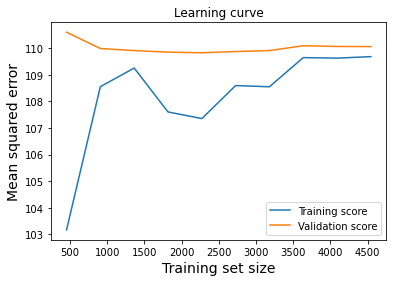

In [4]:
# Learning curve
ridge_reg = Ridge(**ridge.best_params_, random_state=42)

train_sizes=np.arange(0.1,1.1,0.1)
plot_learning_curve(ridge_reg,X_train_comb,y_train,train_sizes,3)

## Model performance and important features
Below, the plot on the left shows the coefficients of the individual features resulting from the linear regression. Since all features are normalized to lie within the range between zero and one, the coefficients of the different features are comparable.
The most important feature is the maximum retail price of the item (the feature "Item_MRP"), the higher the retail price, the higher the sales. There are also significant differences between the kinds of stores. Stores of the type "Supermarket Type 3" have higher sales than the other kinds, grocery stores have far lower sales.

The plot on the right shows a scatter plot of the predicted sales against the true sales for a set of validation data. Here, the strong influence of the maximum retail price and of the type of the store are also evident. The contours outline the 2D kernel density estimate of the scatter plot. The individual contours enclose 10 %, 50 %, 80 %, and 95 % of the data points, respectively. The colors represent the different types of stores (the feature "Outlet_Type"). The black curve represents a perfect model.
For low values of the true sales (lower than about 4000), the predictions roughly follow the true values, although with a considerable amount of scatter. For larger values of the sales, the model starts to underestimate the sales. The correlation coefficient between the true and the predicted sales is 0.78.
As discussed above, the sales depend strongly on the type of the store and the maximum retail price. The majority (65 %) of the stores are in the category "Supermarket Type 1" (as shown in orange in the scatter plot). Since the maximum retail price follows a roughly uniform distribution, there is a sudden cutoff in the predicted sales for stores of the category "Supermarket Type 1" at a value of about 4000. The predicted sales exceed 4000 only for items in stores of the type "Supermarket Type 3". 

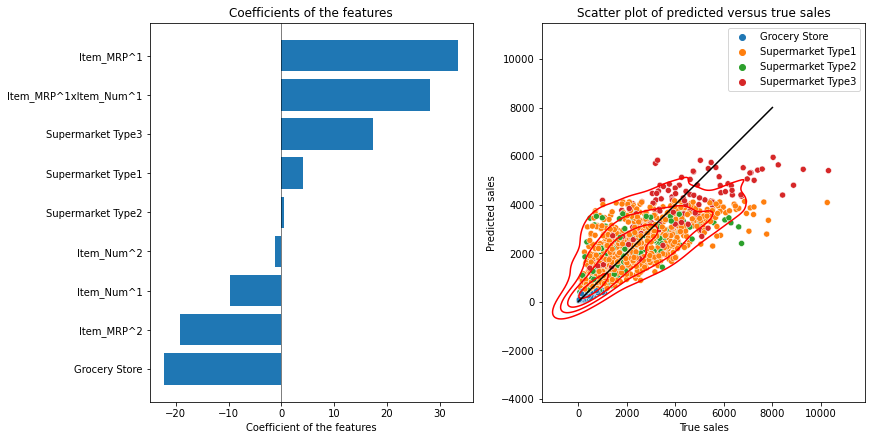

In [5]:
# Apply the Ridge regression model to a set of validation data
X_train2, X_val, y_train2, y_val = train_test_split(X_train_comb,y_train,test_size=0.2,random_state=42,stratify=X_train['Outlet_Identifier'])
ridge_reg.fit(X_train2,y_train2)
y_pred = ridge_reg.predict(X_val)


# Plot the coefficients of the features
fig, ax = plt.subplots(1,2,figsize=[12,6],constrained_layout = True)
sorted_idx = ridge_reg.coef_.argsort()
ax[0].barh(X_train2.columns[sorted_idx],ridge_reg.coef_[sorted_idx])
ax[0].axvline(x=0, ymin=0, ymax=1,color='k',linewidth=0.5)
ax[0].set_xlabel('Coefficient of the features')
ax[0].set_title('Coefficients of the features');


# Plot a scatter plot between the true and the predicted sales for the validation data
store_type = X_val[['Grocery Store','Supermarket Type1','Supermarket Type2','Supermarket Type3']].idxmax(axis=1)

sns.scatterplot(x=y_val**2,y=y_pred**2,ax=ax[1],hue=store_type,hue_order=['Grocery Store','Supermarket Type1','Supermarket Type2','Supermarket Type3'])
sns.kdeplot(x=y_val**2,y=y_pred**2,color='r',levels=[0.05,0.2,0.5,0.9],ax=ax[1])
ax[1].plot([0,8e3],[0,8e3],'k')
ax[1].axis('equal')
ax[1].set_xlabel('True sales')
ax[1].set_ylabel('Predicted sales')
ax[1].set_title('Scatter plot of predicted versus true sales');

## Test data
In the last step, I evaluate the model using the test data. The resulting mean squared error (104.6) is slightly lower than the one achieved in the cross-validation (MSE = 110).
For comparison, the variance of the sales in the test data is 322.6.

In [6]:
# MSE of the test data
test_score = mean_squared_error(y_test,ridge_reg.predict(X_test_comb))

display('Test data: MSE =  {:.2f}'.format(test_score))

'Test data: MSE =  104.56'

## Application of the model: predicting the sales in a new store
When Big Mart is about to open a new store, it is important to get an estimate of the sales for each product in the new store. Predicting these sales is a potential application of the Ridge regression model derived in this notebook.

In the following, the outlet with the identifier "OUT013" represents a store that is supposed to be opened. I train a Ridge regression using the sales in the other stores as training data and evaluate its performance in predicting the sales for "OUT013".

The plot below shows a scatter plot of the sales predicted by the model against the true sales for "OUT013". The model achieves an MSE of 124 and the correlation between true and predicted sales is 0.70. As explained in the README, the sales in "OUT013" can also be predicted using the sales of the other stores as features (see predict_single_store.ipynb). The performance of such a model (correlation 0.73) is similar to the current one.


### Comparison with a simple model for the sales in the new store
In the analysis above, I evaluated the performance of the model in absolute terms. However, it is unclear whether this model performs better than a more simple approach (ideally the one that has been used in the past). An example for a more simple model would be to assume that the sales in the new store correspond to the mean of the sales in the existing stores for each item.

As can be seen below, the mean squared error (MSE) of the Ridge regression is 30 % lower than the one of the simple model. Hence, the model derived in this notebook offers a significant advantage compared to a more simple approach.

Text(0, 0.5, 'Predicted sales')

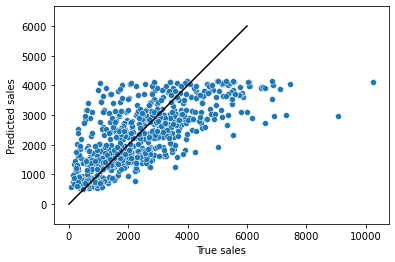

In [7]:
# Predicting the sales for the outlet "OUT013". I use the sales in the other stores as training data.
store = 'OUT013'

ind = X_train['Outlet_Identifier'] == store
X_train3 = X_train_comb[~ind]
y_train3 = y_train[~ind]

X_val3 = X_train_comb[ind]
y_val3 = y_train[ind]

# Fit the Ridge regression and predict the sales for the store "OUT013"
ridge_reg.fit(X_train3,y_train3)
y_pred3 = ridge_reg.predict(X_val3)


# Plot a scatter plot between the true and the predicted sales for the store "OUT013"
fig, ax = plt.subplots()
sns.scatterplot(x=y_val3**2,y=y_pred3**2)
ax.plot([0,6e3],[0,6e3],'k')
ax.axis('equal')
ax.set_xlabel('True sales')
ax.set_ylabel('Predicted sales')
# ax.set_title('Scatter plot of predicted versus true sales');

In [8]:
# Comparison with a simple model
# (predict the sales in the new store to be the mean of the sales in the existing stores for each product)

# Get the list of items that are supposed to be sold in the new store
store_items = X.Item_Identifier[X_val3.index]

# Get the indices of these items for all existing stores in the dataframe X
items_indices = X[(X.Outlet_Identifier != store) & X.Item_Identifier.isin(store_items)].index

# Create a dataframe consisting of the sales of these items in the existing stores
items_sales = pd.concat([X.Item_Identifier,X.Outlet_Identifier,y],axis=1)
items_sales.index = X.index
items_sales = items_sales[items_sales.index.isin(items_indices)]

# Create a pivot table of items_sales with the items being the rows and the stores being the columns
data_p = items_sales.pivot(index='Item_Identifier',columns='Outlet_Identifier',values='Item_Outlet_Sales')
data_p = data_p.loc[store_items] # sort items to be in the same order as in the validation data X_val3

# Calculate the mean sales for the existing stores
mean_sales = data_p.mean(axis=1)

# Calculate the mean squared error (MSE) for the validation data and for the simple model (the mean sales of the existing stores)
MSE_val = mean_squared_error(y_val3,ridge_reg.predict(X_val3)) # MSE of the Lasso regression
MSE_simple = mean_squared_error(y_val3,mean_sales) # MSE of the simple model
display('Ridge regression: MSE = {:.2f}'.format(MSE_val))
display('Mean of the sales in the existing stores: MSE = {:.2f}'.format(MSE_simple))

'Ridge regression: MSE = 123.56'

'Mean of the sales in the existing stores: MSE = 176.89'

## Summary
This notebook makes use of a Ridge regression to predict the sales for each individual product in the different stores for Big Mart. The model achieves an MSE of 110 (when taking the square root of the sales) and the correlation coefficient between the predicted and the true sales is 0.78.
The most important features are the maximum retail price of the individual products and the type of the store where they are being sold. According to the learning curve, the model is dominated by bias. Therefore, a better model would require additional relevant features.

How to improve the model depends also on what exactly the model is supposed to predict. In its current form, the model predicts the sales of each item in the individual outlets. Most likely, the model would not perform well in forecasting the sales for the next month or year, since it does not incorporate a time-series of sales data. Instead, it predicts the sales of products based on the properties of the items and the stores, where they are being sold. This makes the model well-suited for predicting the sales of new items. When a new product gets introduced by Big Mart, this model allows predicting its sales in the individual outlets based on the properties of the item. Such a prediction would benefit from additional information about the different products.

Another potential application would be to predict the sales in a new store (see the example above). Here, the Ridge regression performs significantly better than more simple models (such as predicting the sales as the mean over the existing stores). However, this question can also be addressed with a more simple model, where the sales of the different items serve as features for the prediction. The notebook predict_single_store.ipynb presents such a model.